# Testing the Memory using a toy problem

Problem and inspiration from the excellent [Mixture Density Networks with TensorFlow](http://blog.otoro.net/2015/11/24/mixture-density-networks-with-tensorflow/).

This notebook was used during development, and can be run to prove the quality of both the Gaussian Mixture and the LSTM.

## Gaussian mixture with a fully connected head

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf

from worldmodels.memory.memory import GaussianMixture, MLP, Memory
from worldmodels.memory.memory import get_pi_idx
from worldmodels.memory.train_memory import train

In [2]:
NSAMPLE = 2500
epochs = 5000

y_data = np.random.uniform(-10.5, 10.5, (1, NSAMPLE)).T
r_data = np.random.normal(size=(NSAMPLE, 1))
x_data = np.sin(0.75*y_data)*7.0+y_data*0.5+r_data*1.0

num_timesteps = 1
num_features = 1
num_mix = 24
batch_size = NSAMPLE

y_data = y_data.reshape(NSAMPLE, num_timesteps, num_features).astype(np.float32)
x_data = x_data.reshape(NSAMPLE, num_timesteps, num_features).astype(np.float32)

#  this will be the shape of the output of the lstm
#  (batch_size, num_timesteps, output_dim * num_mix * 3)
#  three for one pi, mu, sigma for each mixture
mixture_dim = num_features * num_mix * 3

In [3]:
memory = MLP(num_mix, hidden_nodes=24)

In [4]:
mixture = GaussianMixture(num_features, num_mix, num_timesteps=1, batch_size=batch_size)

In [5]:
x_sample = x_data[0:2]
x_sample.shape

(2, 1, 1)

In [6]:
pi, mu, sigma = mixture(memory(x_data))

In [7]:
def train_op(memory, mixture, x, y):
    with tf.GradientTape() as tape:
        loss = mixture.get_loss(memory(x), y)
        gradients = tape.gradient(loss, memory.trainable_variables)

    optimizer.apply_gradients(zip(gradients, memory.trainable_variables))
    return loss

optimizer = tf.keras.optimizers.Adam()
dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data)).shuffle(NSAMPLE).batch(batch_size)
loss = np.zeros(epochs)

for epoch in range(epochs):
    for batch in dataset:
        loss[epoch] = train_op(memory, mixture, *batch)
    if epoch % 500 == 1:
        print(epoch, loss[epoch])

1 7.078389644622803
101 3.55212664604187
201 3.3166725635528564
301 3.1462340354919434
401 2.856743335723877
501 2.5141379833221436
601 2.3666305541992188
701 2.3286614418029785
801 2.3031532764434814
901 2.2829999923706055
1001 2.2667062282562256
1101 2.2537457942962646
1201 2.243251085281372
1301 2.23445987701416
1401 2.2257578372955322
1501 2.2119357585906982
1601 2.189491033554077
1701 2.1652138233184814
1801 2.149012327194214
1901 2.134653091430664
2001 2.123095989227295
2101 2.1139214038848877
2201 2.1055681705474854
2301 2.098475217819214
2401 2.0924222469329834
2501 2.086941719055176
2601 2.082045793533325
2701 2.0777809619903564
2801 2.074172258377075
2901 2.0712380409240723
3001 2.0687410831451416
3101 2.066535234451294
3201 2.064594030380249
3301 2.0628321170806885
3401 2.061215400695801
3501 2.059701681137085
3601 2.0582938194274902
3701 2.056962728500366
3801 2.055706739425659
3901 2.0545077323913574
4001 2.0533576011657715
4101 2.052260637283325
4201 2.051138162612915
430

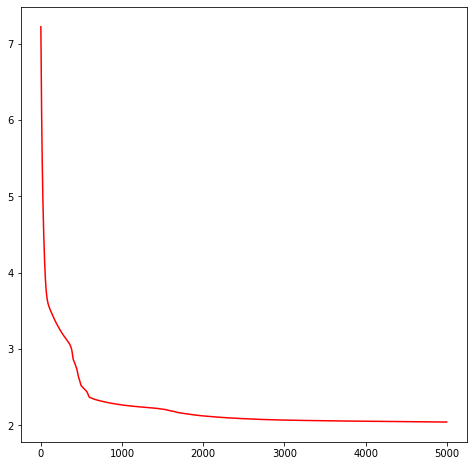

In [8]:
plt.figure(figsize=(8, 8))
plt.plot(np.arange(epochs), loss[:epochs], 'r-')
plt.style.use('ggplot')
plt.show()

In [9]:
x_test = np.float32(np.arange(-15, 15, 0.1))
n_test = x_test.shape[0]
x_test = x_test.reshape(n_test, 1, 1)

In [10]:
mus, sigmas, idxs = np.zeros(n_test), np.zeros(n_test), np.zeros(n_test)
samples = np.zeros(n_test)

for num, sample in enumerate(x_test):
    pi, mu, sigma = mixture(memory(sample.reshape(1, 1, 1)))
    
    pi = np.array(pi).reshape(1, pi.shape[3])
    mu = np.array(mu).reshape(1, mu.shape[3])
    sigma = np.array(sigma).reshape(1, sigma.shape[3])

    idx = get_pi_idx(pi[0], None)
    
    idxs[num] = idx
    mus[num] = mu[:, idx]
    sigmas[num] = sigma[:, idx]
    
    samples[num] = mus[num] + np.random.randn() * sigmas[num]

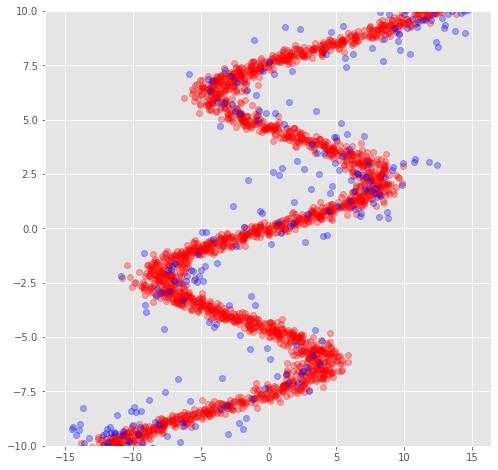

In [11]:
plt.figure(figsize=(8, 8))
plt.plot(np.squeeze(x_data),np.squeeze(y_data), 'ro', np.squeeze(x_test), np.squeeze(samples), 'bo', alpha=0.3)
plt.ylim(-10, 10)
plt.savefig('/Users/adam/git/adgefficiency.github.io/assets/world-models/mdn-test1.png')
plt.show()

## Gaussian mixture with an LSTM head

In [20]:
nodes = 64
num_mix = 64
batch_size = 1024

memory = Memory(
    input_dim=1, 
    output_dim=num_features, 
    num_timesteps=num_timesteps, 
    batch_size=batch_size, 
    lstm_nodes=nodes, 
    num_mix=num_mix,
    initial_learning_rate=0.001,
    end_learning_rate=0.001
)

In [21]:
x = x_data
y = y_data

epochs = 5000
loss = np.zeros(epochs)

dataset = tf.data.Dataset.from_tensor_slices((x, y)).shuffle(1).batch(batch_size)

for epoch in range(epochs):
    batch_losses = []
    for batch in dataset:
        state = memory.lstm.get_zero_hidden_state(batch[0])
        batch_loss = memory.train_op(*batch, state)
        batch_losses.append(batch_loss)

    loss[epoch] = np.mean(batch_losses)
        
    if epoch % 500 == 1:
        print(epoch, loss[epoch])

1 14.648804664611816
51 4.05605936050415
101 3.286832809448242
151 2.740520477294922
201 2.423109292984009
251 2.3147332668304443
301 2.266261339187622
351 2.2415084838867188
401 2.213308572769165
451 2.196223497390747
501 2.183206081390381
551 2.170489549636841
601 2.1574459075927734
651 2.1460771560668945
701 2.1370608806610107
751 2.1267740726470947
801 2.1130106449127197
851 2.0988104343414307
901 2.088879346847534
951 2.0817079544067383
1001 2.075758934020996
1051 2.070301055908203
1101 2.0650265216827393
1151 2.0598182678222656
1201 2.0549230575561523
1251 2.050400733947754
1301 2.045565366744995
1351 2.042698621749878
1401 2.041041612625122
1451 2.0398571491241455
1501 2.038928747177124
1551 2.0381619930267334
1601 2.0375006198883057
1651 2.0369114875793457
1701 2.0363729000091553
1751 2.0358734130859375
1801 2.0354042053222656
1851 2.0349624156951904
1901 2.0345425605773926
1951 2.0341403484344482
2001 2.0337514877319336
2051 2.033372640609741
2101 2.032999277114868
2151 2.0326

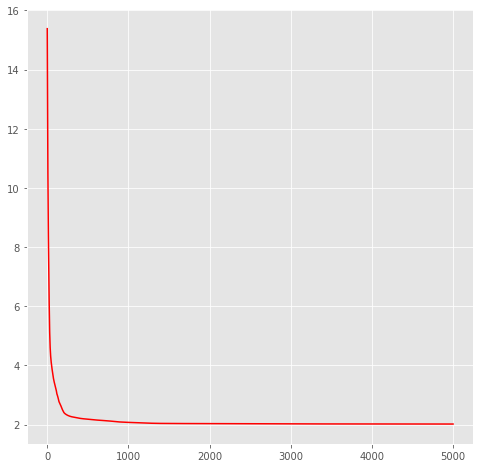

In [22]:
plt.figure(figsize=(8, 8))
plt.plot(np.arange(epochs), loss[:epochs], 'r-')
plt.show()

In [23]:
#  need to save & load to use a different batch size (when predicting on test)
memory.save('./mdl')

memory = Memory(
    input_dim=1, 
    output_dim=num_features, 
    num_timesteps=num_timesteps, 
    batch_size=batch_size, 
    lstm_nodes=nodes, 
    num_mix=num_mix
)

memory.load('./mdl')

saving model to ./mdl/models
loading model from ./mdl/models


In [24]:
mus, sigmas, idxs, samples = np.zeros(n_test), np.zeros(n_test), np.zeros(n_test), np.zeros(n_test)

for num, sample in enumerate(x_test):
    sample = sample.reshape(1, 1, 1)
    state = memory.lstm.get_zero_hidden_state(sample)
    latent, _, _ = memory.lstm.net(sample, state)
    pi, mu, sigma = memory.mixture(latent)
    idx = get_pi_idx(tf.reshape(pi, (num_mix,)), None)
    
    idxs[num] = idx
    mus[num] = mu[:, :, :, idx]
    sigmas[num] = sigma[:, :, :, idx]
    
    samples[num] = mus[num] + np.random.randn() * sigmas[num]

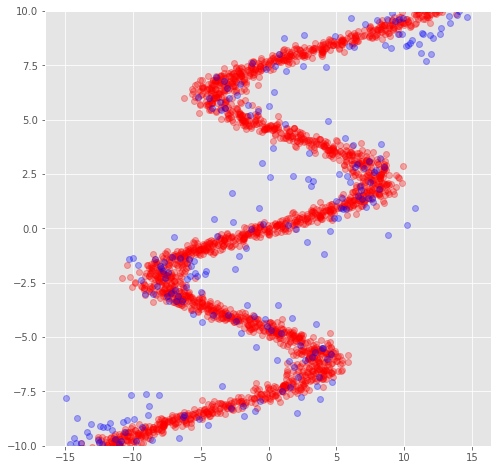

In [25]:
plt.figure(figsize=(8, 8))
plt.plot(np.squeeze(x_data),np.squeeze(y_data), 'ro', np.squeeze(x_test), np.squeeze(samples), 'bo', alpha=0.3)
plt.ylim(-10, 10)
plt.savefig('/Users/adam/git/adgefficiency.github.io/assets/world-models/mdn-test2.png')
plt.show()